In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scoutiumdataset/scoutium_potential_labels.csv
/kaggle/input/scoutiumdataset/scoutium_attributes.csv


In [2]:
import warnings
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler
warnings.simplefilter(action='ignore', category=Warning)



from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)


In [3]:
    
df1=pd.read_csv("/kaggle/input/scoutiumdataset/scoutium_attributes.csv",sep=";")
df2=pd.read_csv("/kaggle/input/scoutiumdataset/scoutium_potential_labels.csv",sep=";")
df=df1.merge(df2,on="player_id",how="inner")

In [4]:
df.head()

,task_response_id_x,match_id_x,evaluator_id_x,player_id,position_id,analysis_id,attribute_id,attribute_value,task_response_id_y,match_id_y,evaluator_id_y,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,4915,62935,177676,average
1,4915,62935,177676,1361061,2,12818495,4322,56.0,5319,63696,256441,average
2,4915,62935,177676,1361061,2,12818495,4322,56.0,5587,64045,256441,highlighted
3,4915,62935,177676,1361061,2,12818495,4323,56.0,4915,62935,177676,average
4,4915,62935,177676,1361061,2,12818495,4323,56.0,5319,63696,256441,average


In [5]:
df["player_id"].value_counts()

player_id
1361061    306
1364951    306
1361626    306
1369065    306
1370976    306
          ... 
1599670     25
1358124     25
1371143     25
1717975     25
1796354     25
Name: count, Length: 277, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   task_response_id_x  14126 non-null  int64  
 1   match_id_x          14126 non-null  int64  
 2   evaluator_id_x      14126 non-null  int64  
 3   player_id           14126 non-null  int64  
 4   position_id         14126 non-null  int64  
 5   analysis_id         14126 non-null  int64  
 6   attribute_id        14126 non-null  int64  
 7   attribute_value     14126 non-null  float64
 8   task_response_id_y  14126 non-null  int64  
 9   match_id_y          14126 non-null  int64  
 10  evaluator_id_y      14126 non-null  int64  
 11  potential_label     14126 non-null  object 
dtypes: float64(1), int64(10), object(1)
memory usage: 1.3+ MB


In [7]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    # print("##################### Quantiles #####################")
    # print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [8]:
check_df(df)

##################### Shape #####################
(14126, 12)
##################### Types #####################
task_response_id_x      int64
match_id_x              int64
evaluator_id_x          int64
player_id               int64
position_id             int64
analysis_id             int64
attribute_id            int64
attribute_value       float64
task_response_id_y      int64
match_id_y              int64
evaluator_id_y          int64
potential_label        object
dtype: object
##################### Head #####################
   task_response_id_x  match_id_x  evaluator_id_x  player_id  position_id  analysis_id  attribute_id  attribute_value  task_response_id_y  match_id_y  evaluator_id_y potential_label
0                4915       62935          177676    1361061            2     12818495          4322             56.0                4915       62935          177676         average
1                4915       62935          177676    1361061            2     12818495          4322 

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [10]:

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


In [11]:

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [12]:

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


In [13]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)


In [14]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [15]:
for col in cat_cols:
    cat_summary(df, col)

                 potential_label      Ratio
potential_label                            
average                    11018  77.998018
highlighted                 2972  21.039218
below_average                136   0.962764
##########################################


In [16]:
for col in num_cols:
    num_summary(df, col)

count    14126.000000
mean      5243.755274
std        266.058115
min       4915.000000
5%        4915.000000
10%       4929.000000
20%       4970.000000
30%       5006.000000
40%       5036.000000
50%       5162.000000
60%       5319.000000
70%       5465.000000
80%       5579.000000
90%       5618.000000
95%       5639.000000
99%       5642.000000
max       5642.000000
Name: task_response_id_x, dtype: float64
count    14126.000000
mean     63250.680731
std        619.566020
min      60549.000000
5%       61923.000000
10%      62935.000000
20%      62944.000000
30%      63032.000000
40%      63061.000000
50%      63166.000000
60%      63406.000000
70%      63627.000000
80%      63696.000000
90%      64045.000000
95%      64045.000000
99%      64045.000000
max      64045.000000
Name: match_id_x, dtype: float64
count     14126.000000
mean     177615.493983
std       44678.299853
min      130478.000000
5%       132337.000000
10%      132337.000000
20%      151191.000000
30%      151191.0

In [17]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
task_response_id_x,14126.0,5.243755e+03,266.058115,4915.0,5003.0,5162.0,5524.0,5642.0
match_id_x,14126.0,6.325068e+04,619.566020,60549.0,62988.0,63166.0,63627.0,64045.0
evaluator_id_x,14126.0,1.776155e+05,44678.299853,130478.0,151191.0,151191.0,186987.0,256441.0
player_id,14126.0,1.502585e+06,197918.601643,1355710.0,1367560.0,1371159.0,1717709.0,1909728.0
position_id,14126.0,5.385389e+00,2.883336,1.0,2.0,6.0,8.0,10.0
analysis_id,14126.0,1.282233e+07,2651.914684,12818481.0,12819662.0,12822225.0,12825048.0,12825764.0
attribute_id,14126.0,4.348610e+03,26.976606,4322.0,4330.0,4342.0,4353.0,4426.0
attribute_value,14126.0,5.636132e+01,15.569218,1.0,45.0,56.0,67.0,100.0
task_response_id_y,14126.0,5.243755e+03,266.058115,4915.0,5003.0,5162.0,5524.0,5642.0
match_id_y,14126.0,6.325068e+04,619.566020,60549.0,62988.0,63166.0,63627.0,64045.0


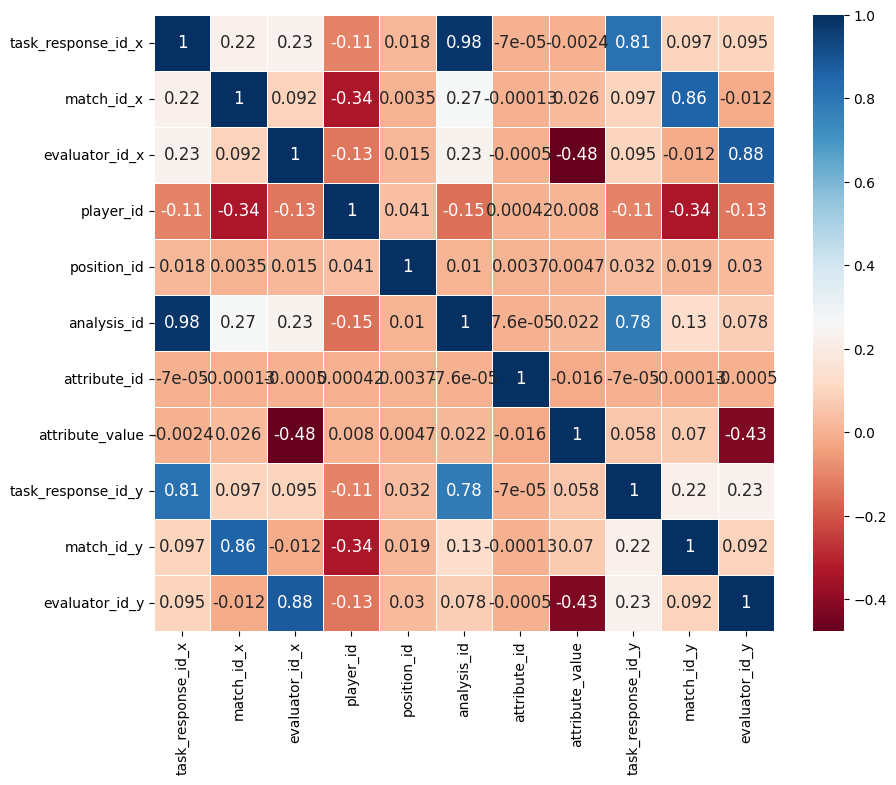

In [18]:
#Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   task_response_id_x  14126 non-null  int64  
 1   match_id_x          14126 non-null  int64  
 2   evaluator_id_x      14126 non-null  int64  
 3   player_id           14126 non-null  int64  
 4   position_id         14126 non-null  int64  
 5   analysis_id         14126 non-null  int64  
 6   attribute_id        14126 non-null  int64  
 7   attribute_value     14126 non-null  float64
 8   task_response_id_y  14126 non-null  int64  
 9   match_id_y          14126 non-null  int64  
 10  evaluator_id_y      14126 non-null  int64  
 11  potential_label     14126 non-null  object 
dtypes: float64(1), int64(10), object(1)
memory usage: 1.3+ MB


In [20]:

# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "potential_label", col)

                 task_response_id_x
potential_label                    
average                 5254.068070
below_average           5149.250000
highlighted             5209.847577


                   match_id_x
potential_label              
average          63254.101380
below_average    63213.750000
highlighted      63239.689435


                 evaluator_id_x
potential_label                
average           176262.813487
below_average     147764.000000
highlighted       183996.260094


                    player_id
potential_label              
average          1.496886e+06
below_average    1.470573e+06
highlighted      1.525180e+06


                 position_id
potential_label             
average             5.218370
below_average       6.250000
highlighted         5.965007


                  analysis_id
potential_label              
average          1.282244e+07
below_average    1.282118e+07
highlighted      1.282199e+07


                 attribute_id
potential_label        

Aykırı Gözlem İnceleme


In [21]:

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [22]:

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [23]:

def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [24]:
for col in num_cols:
    print(col,":",check_outlier(df,col))

task_response_id_x : False
match_id_x : False
evaluator_id_x : False
player_id : False
position_id : False
analysis_id : False
attribute_id : False
attribute_value : False
task_response_id_y : False
match_id_y : False
evaluator_id_y : False


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   task_response_id_x  14126 non-null  int64  
 1   match_id_x          14126 non-null  int64  
 2   evaluator_id_x      14126 non-null  int64  
 3   player_id           14126 non-null  int64  
 4   position_id         14126 non-null  int64  
 5   analysis_id         14126 non-null  int64  
 6   attribute_id        14126 non-null  int64  
 7   attribute_value     14126 non-null  float64
 8   task_response_id_y  14126 non-null  int64  
 9   match_id_y          14126 non-null  int64  
 10  evaluator_id_y      14126 non-null  int64  
 11  potential_label     14126 non-null  object 
dtypes: float64(1), int64(10), object(1)
memory usage: 1.3+ MB


In [26]:
## position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız.##

df = df[df['position_id'] != 1]
df['position_id'].value_counts()

position_id
2     2686
6     1870
10    1462
8     1462
9     1190
3     1190
5     1156
7     1122
4     1088
Name: count, dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13226 entries, 0 to 14125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   task_response_id_x  13226 non-null  int64  
 1   match_id_x          13226 non-null  int64  
 2   evaluator_id_x      13226 non-null  int64  
 3   player_id           13226 non-null  int64  
 4   position_id         13226 non-null  int64  
 5   analysis_id         13226 non-null  int64  
 6   attribute_id        13226 non-null  int64  
 7   attribute_value     13226 non-null  float64
 8   task_response_id_y  13226 non-null  int64  
 9   match_id_y          13226 non-null  int64  
 10  evaluator_id_y      13226 non-null  int64  
 11  potential_label     13226 non-null  object 
dtypes: float64(1), int64(10), object(1)
memory usage: 1.3+ MB


In [28]:

##  potential_label içerisindeki below_average sınıfını veri setinden kaldırınız.( below_average sınıfı tüm verisetinin %1'ini oluşturur)

df=df[df["potential_label"]!="below_average"]
df["potential_label"].value_counts()

potential_label
average        10268
highlighted     2822
Name: count, dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13090 entries, 0 to 14125
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   task_response_id_x  13090 non-null  int64  
 1   match_id_x          13090 non-null  int64  
 2   evaluator_id_x      13090 non-null  int64  
 3   player_id           13090 non-null  int64  
 4   position_id         13090 non-null  int64  
 5   analysis_id         13090 non-null  int64  
 6   attribute_id        13090 non-null  int64  
 7   attribute_value     13090 non-null  float64
 8   task_response_id_y  13090 non-null  int64  
 9   match_id_y          13090 non-null  int64  
 10  evaluator_id_y      13090 non-null  int64  
 11  potential_label     13090 non-null  object 
dtypes: float64(1), int64(10), object(1)
memory usage: 1.3+ MB


In [30]:
## İndekste “player_id”,“position_id” ve “potential_label”, sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan
# “attribute_value” olacak şekilde pivot table’ı oluşturunuz.
pivot_df=pd.pivot_table(df,values='attribute_value', index=['player_id',"position_id","potential_label"], columns='attribute_id')

### “reset_index” fonksiyonunu kullanarak indeksleri değişken olarak atayınız ve “attribute_id” sütunlarının isimlerini stringe çeviriniz.
pivot_df = pivot_df.reset_index()
pivot_df.columns = pivot_df.columns.astype(str)
pivot_df

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,45.0,50.5,56.0,39.5,34.0,39.5,39.5,45.0,45.0,50.5,28.5,23.0,39.5,28.5,28.5,45.0,50.5,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,78.0,56.0,67.0,67.0,67.0,78.0,78.0,56.0,67.0,67.0,45.0,45.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,67.0,89.0,78.0,67.0,67.0,67.0,56.0,56.0,67.0,78.0,56.0,56.0,67.0,56.0,67.0,56.0,67.0,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1907347,5,average,67.0,78.0,78.0,56.0,78.0,67.0,78.0,67.0,56.0,78.0,78.0,56.0,67.0,67.0,78.0,56.0,67.0,56.0,56.0,67.0,78.0,89.0,67.0,78.0,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
282,1907347,6,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,78.0,56.0,67.0,67.0,67.0,67.0,78.0,67.0,56.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
283,1909532,10,average,56.0,45.0,45.0,45.0,56.0,56.0,56.0,56.0,23.0,23.0,34.0,45.0,56.0,34.0,23.0,45.0,45.0,23.0,23.0,34.0,23.0,23.0,34.0,23.0,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
284,1909724,2,highlighted,78.0,78.0,78.0,78.0,78.0,78.0,78.0,78.0,67.0,67.0,78.0,78.0,78.0,67.0,78.0,67.0,78.0,56.0,56.0,78.0,78.0,67.0,78.0,78.0,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


In [31]:
##Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade ediniz.

le=LabelEncoder()
pivot_df["potential_label"]=le.fit_transform(pivot_df["potential_label"])
pivot_df["potential_label"]


0      0
1      0
2      0
3      0
4      0
      ..
281    0
282    0
283    0
284    1
285    1
Name: potential_label, Length: 286, dtype: int64

In [32]:
cat_cols, num_cols, cat_but_car = grab_col_names(pivot_df, cat_th=5, car_th=20)
print("Num Cols",num_cols)
print("Cat Cols",cat_cols)
print("Cat_but_car",cat_but_car)

Num Cols ['player_id', 'position_id', '4322', '4323', '4324', '4325', '4326', '4327', '4328', '4329', '4330', '4332', '4333', '4335', '4338', '4339', '4340', '4341', '4342', '4343', '4344', '4345', '4348', '4349', '4350', '4351', '4352', '4353', '4354', '4355', '4356', '4357', '4407', '4408', '4423', '4426']
Cat Cols ['potential_label']
Cat_but_car []


In [33]:
#  Kaydettiğiniz bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için StandardScaler uygulayınız.
ss=StandardScaler().fit_transform(pivot_df[num_cols])
pivot_df[num_cols] = pd.DataFrame(ss, columns=pivot_df[num_cols].columns)

In [34]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   player_id        286 non-null    float64
 1   position_id      286 non-null    float64
 2   potential_label  286 non-null    int64  
 3   4322             286 non-null    float64
 4   4323             286 non-null    float64
 5   4324             286 non-null    float64
 6   4325             286 non-null    float64
 7   4326             286 non-null    float64
 8   4327             286 non-null    float64
 9   4328             286 non-null    float64
 10  4329             286 non-null    float64
 11  4330             286 non-null    float64
 12  4332             286 non-null    float64
 13  4333             286 non-null    float64
 14  4335             286 non-null    float64
 15  4338             286 non-null    float64
 16  4339             286 non-null    float64
 17  4340            

In [35]:
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mode()[0]) if x.name != 'potential_label' else x, axis=0)

In [36]:
y = pivot_df["potential_label"]
X = pivot_df.drop(["potential_label"], axis=1)

In [37]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [38]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   player_id        286 non-null    float64
 1   position_id      286 non-null    float64
 2   potential_label  286 non-null    int64  
 3   4322             286 non-null    float64
 4   4323             286 non-null    float64
 5   4324             286 non-null    float64
 6   4325             286 non-null    float64
 7   4326             286 non-null    float64
 8   4327             286 non-null    float64
 9   4328             286 non-null    float64
 10  4329             286 non-null    float64
 11  4330             286 non-null    float64
 12  4332             286 non-null    float64
 13  4333             286 non-null    float64
 14  4335             286 non-null    float64
 15  4338             286 non-null    float64
 16  4339             286 non-null    float64
 17  4340            

In [39]:
pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
Note: you may need to restart the kernel to use updated packages.


In [40]:

def base_models(X_res, y_res, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   #'GBM', GradientBoostingClassifier()),
                    #'XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ]
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X_res, y_res, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X_res, y_res, scoring="accuracy")

Base Models....
accuracy: 0.6554 (LR) 
accuracy: 0.6644 (KNN) 
accuracy: 0.6802 (SVC) 
accuracy: 0.5698 (CART) 
accuracy: 0.714 (RF) 
accuracy: 0.4932 (Adaboost) 


In [41]:
base_models(X_res, y_res, scoring="f1")

Base Models....
f1: 0.6986 (LR) 
f1: 0.7343 (KNN) 
f1: 0.7246 (SVC) 
f1: 0.6377 (CART) 
f1: 0.7563 (RF) 
f1: 0.6305 (Adaboost) 


In [42]:
base_models(X_res, y_res, scoring="precision")

Base Models....
precision: 0.6355 (LR) 
precision: 0.6076 (KNN) 
precision: 0.6448 (SVC) 
precision: 0.5676 (CART) 
precision: 0.6581 (RF) 
precision: 0.4957 (Adaboost) 


In [43]:
base_models(X_res, y_res, scoring="recall")

Base Models....
recall: 0.7838 (LR) 
recall: 0.9279 (KNN) 
recall: 0.8288 (SVC) 
recall: 0.7928 (CART) 
recall: 0.8874 (RF) 
recall: 0.8694 (Adaboost) 
